## v3 Pre-Trained Model with SGD as an Optimizer

My final attempt at improvement began with modifying the optimizer to utilize SGD. While I was not confident this would be better than Adam, I am more familiar with it and with my ultimate goal being to learn, I wanted something that I was more comfortable tweaking. 

In the below implementation, I have updated the optimizer, matained the batch size at 32, upped the learning rate to .001, implemented a momentum of .9, implemented weight decay to penalize large weights and reduced the epoch to 10. 

C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=In

Epoch [1/10], Step [1/32], Loss: 4.0614
Epoch [1/10], Step [6/32], Loss: 3.6748
Epoch [1/10], Step [11/32], Loss: 2.7952
Epoch [1/10], Step [16/32], Loss: 2.1971
Epoch [1/10], Step [21/32], Loss: 1.2617
Epoch [1/10], Step [26/32], Loss: 0.9447
Epoch [1/10], Step [31/32], Loss: 0.7730
Epoch [1/10], Train Loss: 2.2521, Val Loss: 0.5165
Epoch [1/10], Train Accuracy: 62.30%, Val Accuracy: 73.50%
Epoch [2/10], Step [1/32], Loss: 0.9068
Epoch [2/10], Step [6/32], Loss: 0.8039
Epoch [2/10], Step [11/32], Loss: 0.8604
Epoch [2/10], Step [16/32], Loss: 0.9285
Epoch [2/10], Step [21/32], Loss: 0.6226
Epoch [2/10], Step [26/32], Loss: 0.5286
Epoch [2/10], Step [31/32], Loss: 0.6374
Epoch [2/10], Train Loss: 0.7381, Val Loss: 0.4680
Epoch [2/10], Train Accuracy: 77.90%, Val Accuracy: 78.00%
Epoch [3/10], Step [1/32], Loss: 0.6025
Epoch [3/10], Step [6/32], Loss: 0.4930
Epoch [3/10], Step [11/32], Loss: 0.5783
Epoch [3/10], Step [16/32], Loss: 0.7602
Epoch [3/10], Step [21/32], Loss: 0.4427
Epoch [

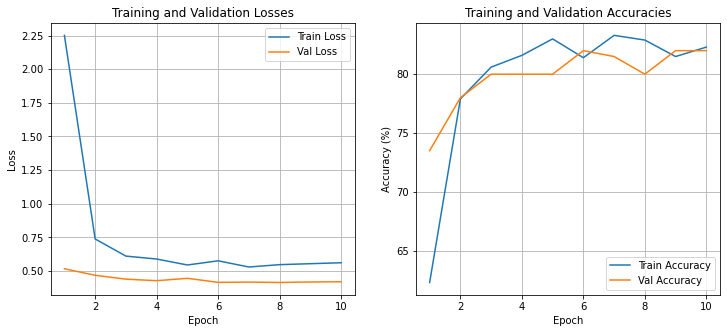

In [1]:
import pandas as pd
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms

# Hyperparameters
batch_size = 32
learning_rate = 0.001
momentum = 0.9
weight_decay = 1e-4
num_epochs = 10
early_stopping_patience = 3
print_freq = 5  # Frequency of printing progress

# Define transformation
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
])

val_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Define the path to the train labels CSV file
csv_file_path = r'MSDS\DL\histopathologic-cancer-detection\train_labels.csv'

# Load the train labels CSV file
train_df = pd.read_csv(csv_file_path)

# Create a dictionary of labels from the DataFrame
labels_dict = {row['id']: row['label'] for idx, row in train_df.iterrows()}

# directory
train_dir = r'MSDS\DL\histopathologic-cancer-detection\train'

# Get all image IDs from the train directory
train_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(train_dir, '*.tif'))]

# Split the train data into train and validation sets
train_ids, val_ids = train_test_split(train_image_ids, test_size=0.1, random_state=42)

# Define CancerDataset class
class CancerDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None, labels_dict={}):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform
        self.labels_dict = labels_dict

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        label = self.labels_dict.get(self.image_ids[idx], 0)
        return image, label

# Instantiate datasets
train_dataset = CancerDataset(datafolder=train_dir, image_ids=train_ids[:1000], transform=train_transform, labels_dict=labels_dict)  # Use a subset for quick testing
val_dataset = CancerDataset(datafolder=train_dir, image_ids=val_ids[:200], transform=val_transform, labels_dict=labels_dict)  # Use a subset for quick testing

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Load pre-trained Inception v3 model
model = models.inception_v3(pretrained=True)

# Modify the final fully connected layer for 2 classes (binary)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer with momentum and weight decay
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Initialize lists to store losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Early stopping parameters
best_val_loss = float('inf')
patience_counter = 0

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, aux_outputs = model(images)  # Inception v3 has auxiliary outputs
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # Combine both losses
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * images.size(0)  # Multiply by batch size

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if i % print_freq == 0:  # Print progress every print_freq batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    
    # Calculate average training loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * images.size(0)  # Multiply by batch size
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    # Calculate average validation loss and accuracy for the epoch
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(epoch_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print and store losses and accuracies
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Accuracy: {train_accuracy:.2f}%, Val Accuracy: {val_accuracy:.2f}%')
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_v3.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break
    
    # Step the learning rate scheduler
    scheduler.step()

# Load the best model
model.load_state_dict(torch.load('best_model_v3.pth'))

# Plotting the losses and accuracies
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Losses')
ax1.legend()
ax1.grid(True)

ax2.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy')
ax2.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Val Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracies')
ax2.legend()
ax2.grid(True)

plt.show()


Overall, this model performs well with an accuracy of 82% and runs much faster compared to the model created from scratch. 

## Testing and Result

This model achieved a public score of 0.8277 on Kaggle. 

In [2]:
import pandas as pd
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn

# Hyperparameters
batch_size = 32

# Define transformation for test images (only resizing)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize to 299x299 for Inception v3
    transforms.ToTensor(),
])

# Define the test directory
test_dir = r'MSDS\DL\histopathologic-cancer-detection\test'

# Get all image IDs from the test directory
test_image_ids = [os.path.splitext(os.path.basename(f))[0] for f in glob.glob(os.path.join(test_dir, '*.tif'))]

# Define TestDataset class
class TestDataset(Dataset):
    def __init__(self, datafolder, image_ids, transform=None):
        self.datafolder = datafolder
        self.image_ids = image_ids
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_name = os.path.join(self.datafolder, f"{self.image_ids[idx]}.tif")
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image, self.image_ids[idx]

# Instantiate the test dataset
test_dataset = TestDataset(datafolder=test_dir, image_ids=test_image_ids, transform=test_transform)

# Create a data loader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Load pre-trained GoogLeNet (Inception v3) model
model = models.inception_v3(pretrained=True)

# Modify the final fully connected layer for 2 classes
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)

# Load the best model weights
model.load_state_dict(torch.load('best_model_v3.pth'))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set the model to evaluation mode
model.eval()

# Dictionary to store predictions
predictions = []

# Test phase
with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for image_id, prediction in zip(image_ids, predicted):
            predictions.append({'id': image_id, 'label': prediction.item()})

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions)

# Save predictions to a CSV file
output_file = r'MSDS\DL\histopathologic-cancer-detection\submission_v3_SGD.csv'
predictions_df.to_csv(output_file, index=False)

print(f"Predictions saved to {output_file}")


C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vinins2\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predictions saved to C:\Users\vinins2\OneDrive - Medtronic PLC\MSDS\DL\histopathologic-cancer-detection\submission_v3_SGD.csv


## Conclusion

Overall, my model exceeded my expectations with its performance. I believe, with more time, I could even improve its performance. For instance, I was not able to get a sort of grid search optimization for the hyper parameters to work and instead resorted to manual tuining. I have found sources online where this was completed so I believe it is possible but it utilizes libraries andc techniques I am not familiar with yet. Future work would be implementing optimization for the tuining to see the ideal parameters needed in theory. 

Additionally, my pre trained model showed significant improvement in efficiency which was expected. When you have a team of professionals dedicating all of their time to a deep learning model designed to classifiy images, it should be efficent otherwise it could prevent the model from being adopted. 

In conclusion, I accomplished my goal of achieveing a performance of over 80% during training and believe I have developed and honed my technique. However, I acknowledge I have only scratched the surface and look forward to learning more on this topic. 